# Example: Find optimal seismic arrays using pre-computed NRMS

Set the backend of matplotlib to the 'inline' backend (specific for Jupyter notebooks) so that result of all plotting commands is displayed inline directly below the code cell that produces it.

In [1]:
 %matplotlib inline

#### Import the standard and third party Python libraries.

In [2]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.max_open_warning'] = 0

sys.path.insert(0, os.sep.join(['..', '..', 'src']))

from ramp.components.seismic.seismic_configuration import SeismicSurveyConfiguration, five_n_receivers_array_creator

from ramp.optimize.ttd_det_optimization import *

#### Setup arguments of seismic survey configuration for all available sources and receivers.

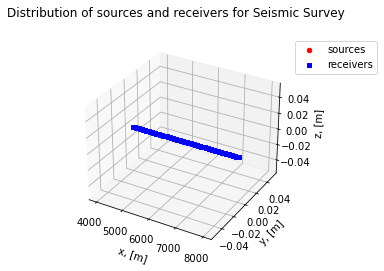

In [3]:
# Define coordinates of sources
num_sources = 9
sources = np.c_[4000 + np.array([240, 680, 1120, 1600, 2040, 2480, 2920, 3400, 3840]),
                np.zeros(num_sources),
                np.zeros(num_sources)]

# Define coordinates of receivers
num_receivers = 101
receivers = np.c_[4000 + np.linspace(0, 4000, num=num_receivers),
                  np.zeros(num_receivers),
                  np.zeros(num_receivers)]

# Create survey with defined coordinates
survey_config = SeismicSurveyConfiguration(sources, receivers, name='Seismic Survey')
survey_config.plot_configuration()

#### Generate a set of (in this case 498) seismic arrays.

In [4]:
num_arrays, produced_arrays = five_n_receivers_array_creator(sources, receivers)
print(num_arrays, len(produced_arrays))

489 489


#### Load NRMS array data from pre-computed npz file, define threshold. The file arrays_nrms_data_3rd_max_value_300_scenarios.npz can be downloaded from here: https://edx.netl.doe.gov/resource/464c334a-ee86-47e3-8105-ff9f0cba9ee3/download.

In [5]:
nrms = np.load('arrays_nrms_data_3rd_max_value_300_scenarios.npz')['data']
threshold = 50
nrmsBool = np.array(nrms > threshold, dtype='bool')

#### Compute the best possible time to detection and number of leaks detected, using current threshold. This is the best detection possible assuming no cost constraints, i.e., if we carry out 489 seismic surveys and repeat them for all 20 timesteps. The goal is to get close to that performance using only a few seismic surveys.

In [6]:
det_best = 0
ttd_best = []
for iScenario in range(nrms.shape[1]):
    if np.any(nrmsBool[:, iScenario, :]):
        det_best += 1
    if len(np.where(np.any(nrmsBool[:, iScenario, :], axis=0))[0]) > 0:
        ttd_best += [np.min(np.where(np.any(nrmsBool[:, iScenario, :], axis=0))[0])]

#### Compute every possible monitoring plans containing only one single seismic survey repeated at one timestep, and identify the subset of those monitoring plans composing the Pareto front.

In [7]:
num_scenarios = 300
plans1 = single_array_timings(nrmsBool)
plans1up = find_unique_pareto(plans1)

x1 = np.array([plan[1] for plan in plans1])
y1 = np.array([plan[2] for plan in plans1])
r1 = pareto(x1, y1)

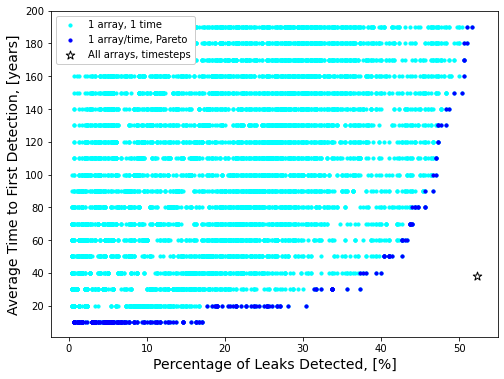

In [8]:
yticks_labels = np.linspace(20, 200, num=10, dtype=int)

plt.figure(figsize=(8, 6))
plt.scatter(100*x1/num_scenarios, 10*y1, s=10, c='cyan', label='1 array, 1 time')
plt.scatter(100*x1[r1==1]/num_scenarios, 10*y1[r1==1], s=10, c='blue', label='1 array/time, Pareto')
plt.scatter(100*det_best/num_scenarios, 10*np.mean(ttd_best), s=80, marker='*', ec='black',
            fc='white', zorder=5, label='All arrays, timesteps')
xlim = plt.xlim()
ylim = plt.ylim()
plt.xlim(xlim)
plt.ylim(ylim)
plt.xlabel('Percentage of Leaks Detected, [%]', fontsize=14)
plt.ylabel('Average Time to First Detection, [years]', fontsize=14)
plt.yticks(yticks_labels)
plt.legend(loc='upper left', framealpha=1.0)
plt.show()

#### Take previous Pareto front monitoring plans, and consider every possible additional survey geometry and timestep that could be added. Repeat this process several times.

In [9]:
plans2 = additional_array_timings(plans1up, nrmsBool)
plans2up = find_unique_pareto(plans2)

x2 = np.array([plan[1] for plan in plans2])
y2 = np.array([plan[2] for plan in plans2])
r2 = pareto(x2, y2)

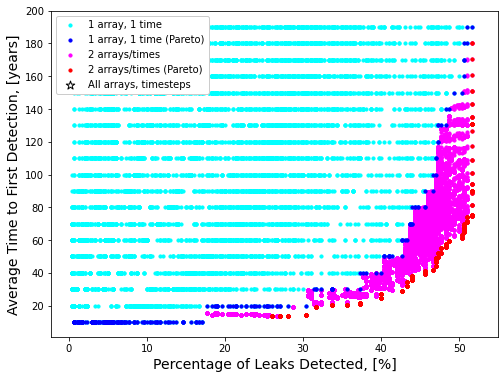

In [10]:
plt.figure(figsize=(8, 6))
plt.scatter(100*x1/num_scenarios, 10*y1, s=10, c='cyan', label='1 array, 1 time')
plt.scatter(100*x1[r1==1]/num_scenarios, 10*y1[r1==1], s=10, c='blue', zorder=4, label='1 array, 1 time (Pareto)')
plt.scatter(100*x2/num_scenarios, 10*y2, s=10, c='magenta', zorder=1, label='2 arrays/times')
plt.scatter(100*x2[r2==1]/num_scenarios, 10*y2[r2==1], s=10, c='red', zorder=2, label='2 arrays/times (Pareto)')
plt.scatter(100*det_best, np.mean(ttd_best), s=80, marker='*', ec='black', fc='white', zorder=5, label='All arrays, timesteps')
plt.xlim(xlim)
plt.ylim(ylim)
plt.xlabel('Percentage of Leaks Detected, [%]', fontsize=14)
plt.ylabel('Average Time to First Detection, [years]', fontsize=14)
plt.yticks(yticks_labels)
plt.legend(loc='upper left', framealpha=1.0)
plt.show()

In [11]:
plans3 = additional_array_timings(plans2up, nrmsBool)
plans3up = find_unique_pareto(plans3)

x3 = np.array([plan[1] for plan in plans3])
y3 = np.array([plan[2] for plan in plans3])
r3 = pareto(x3, y3)

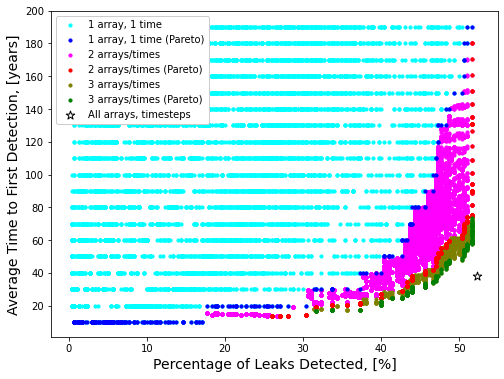

In [12]:
plt.figure(figsize=(8, 6))
plt.scatter(100*x1/num_scenarios, 10*y1, s=10, c='cyan', label='1 array, 1 time')
plt.scatter(100*x1[r1==1]/num_scenarios, 10*y1[r1==1], s=10, c='blue', zorder=4, label='1 array, 1 time (Pareto)')
plt.scatter(100*x2/num_scenarios, 10*y2, s=10, c='magenta', zorder=1, label='2 arrays/times')
plt.scatter(100*x2[r2==1]/num_scenarios, 10*y2[r2==1], s=10, c='red', zorder=2, label='2 arrays/times (Pareto)')
plt.scatter(100*x3/num_scenarios, 10*y3, s=10, c='olive', zorder=1, label='3 arrays/times')
plt.scatter(100*x3[r3==1]/num_scenarios, 10*y3[r3==1], s=10, c='green', zorder=2, label='3 arrays/times (Pareto)')
plt.scatter(100*det_best/num_scenarios, 10*np.mean(ttd_best), s=80, marker='*', ec='black', 
            fc='white', zorder=5, label='All arrays, timesteps')
plt.xlim(xlim)
plt.ylim(ylim)
plt.xlabel('Percentage of Leaks Detected, [%]', fontsize=14)
plt.ylabel('Average Time to First Detection, [years]', fontsize=14)
plt.yticks(yticks_labels)
plt.legend(loc='upper left', framealpha=1.0)
plt.show()

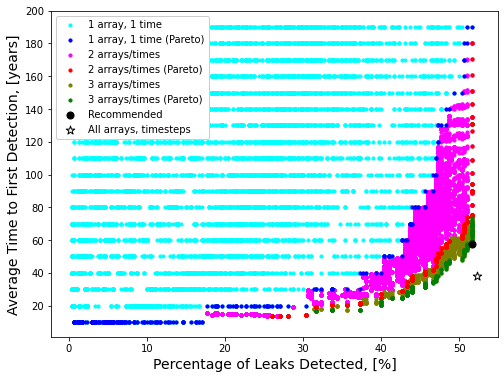

In [13]:
maxDet = np.where(x3==np.max(x3))[0]
ii = np.argsort(y3[maxDet])
iLowestTTDwmaxDet = maxDet[ii][0]

plt.figure(figsize=(8, 6))
plt.scatter(100*x1/num_scenarios, 10*y1, s=10, c='cyan', label='1 array, 1 time')
plt.scatter(100*x1[r1==1]/num_scenarios, 10*y1[r1==1], s=10, c='blue', 
            zorder=4, label='1 array, 1 time (Pareto)')

plt.scatter(100*x2/num_scenarios, 10*y2, s=10, c='magenta', 
            zorder=1, label='2 arrays/times')
plt.scatter(100*x2[r2==1]/num_scenarios, 10*y2[r2==1], s=10, c='red', 
            zorder=2, label='2 arrays/times (Pareto)')

plt.scatter(100*x3/num_scenarios, 10*y3, s=10, c='olive', 
            zorder=1, label='3 arrays/times')
plt.scatter(100*x3[r3==1]/num_scenarios, 10*y3[r3==1], s=10, c='green', 
            zorder=2, label='3 arrays/times (Pareto)')
plt.scatter(100*x3[iLowestTTDwmaxDet]/num_scenarios, 10*y3[iLowestTTDwmaxDet], s=50, c='black', 
            zorder=9, label='Recommended')

plt.scatter(100*det_best/num_scenarios, 10*np.mean(ttd_best), s=80, marker='*', ec='black', fc='white',
            zorder=5, label='All arrays, timesteps')
plt.xlim(xlim)
plt.ylim(ylim)
plt.xlabel('Percentage of Leaks Detected, [%]', fontsize=14)
plt.ylabel('Average Time to First Detection, [years]', fontsize=14)
plt.yticks(yticks_labels)
plt.legend(loc='upper left', framealpha=1.0)
plt.show()

#### Visualize the recommended plan.

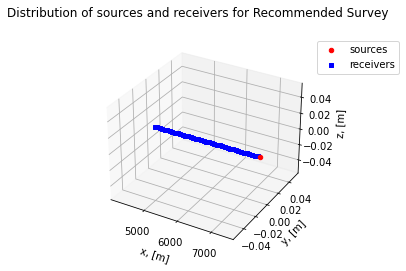

In [14]:
recommendedPlan = list(plans3)[iLowestTTDwmaxDet][0]
#recommendedPlan

num_sources = 9
sources = np.c_[4000 + np.array([240, 680, 1120, 1600, 2040, 2480, 2920, 3400, 3840]),
                np.zeros(num_sources),
                np.zeros(num_sources)]
sources = np.reshape(sources[produced_arrays[recommendedPlan[0][0]]['source']], [1, 3])

num_receivers = 101
receivers = np.c_[4000 + np.linspace(0, 4000, num=num_receivers),
                  np.zeros(num_receivers),
                  np.zeros(num_receivers)]
receivers = receivers[produced_arrays[recommendedPlan[0][0]]['receivers']]

survey_config = SeismicSurveyConfiguration(sources, receivers, name='Recommended Survey')
survey_config.plot_configuration()